# Evaluating speech polarization over time

In [36]:
PATH = "/home/piotr/projects/twitter"
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import gc
import json
import pickle
from datetime import datetime, timedelta
import random
from collections import defaultdict
from tqdm.notebook import tqdm, trange
import itertools
from functools import partial
import os
import ast
import pdb
import sys
sys.path.append(os.path.join(PATH, 'src'))
from twitter_models.polarization import ModelPolarization
from twitter_tools.utils import read_files, clean_tweets, filter_data
from twitter_tools.evaluation import polarization as evaluation
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import logging
import statsmodels.api as sm

In [2]:
PATH_STOPWORDS = '/home/piotr/nlp/polish.stopwords.txt'
stopwords = []
with open(PATH_STOPWORDS, 'r') as f:
    for line in f:
        word = line.strip('\n')
        if word != 'nie':
            stopwords.append(word)
stopwords.append('mieć')
PATH_DROP = os.path.join(PATH, 'results/cleaning/DROP_IDS.json')
START = '2020_02_23'
END = '2020_07_15'
dtypes = json.load(open(os.path.join(PATH, 'results/cleaning/dtypes.json'), 'r'))

In [3]:
gov = pickle.load(open(os.path.join(PATH, 'data/sample/gov_sample.p'),"rb"))
opp = pickle.load(open(os.path.join(PATH, 'data/sample/opp_sample.p'),"rb"))
parties = {k:"gov" for k in gov}
parties.update({k:"opp" for k in opp})
PATH_DATA = os.path.join(PATH, "data/clean")


#Get random assignment
random_keys = list(parties.keys()); random.shuffle(random_keys) #randomize keys
random_values = list(parties.values()); random.shuffle(random_values) #randomize values
randomized = dict(zip(random_keys, random_values)) #zip into dict

The call below writes a new file that contains data from the day-level files filtered using the data filtering function defined above:

In [4]:
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_tweets.json')
drop_tweets = json.load(open(PATH_DROP, 'r'))
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_users.json')
drop_users = json.load(open(PATH_DROP, 'r'))

#filter function:
def filter_fun(df:pd.DataFrame, drop_users:list, drop_tweets:list):
    df = df[np.logical_not(df['user-id_str'].isin(drop_users))] #drop IDs that are to be excluded
    df = df[np.logical_not(df['id_str'].isin(drop_tweets))]
    df.drop_duplicates(inplace = True, subset = ['lemmatized'])
    return df
ff = partial(filter_fun, drop_users = drop_users, drop_tweets = drop_tweets)

# Leave out estimator of partisanship (Gentzkow et al. 2020)

*The leave-out estimator of partisanship is obtained using the following process. Each user's speech-generating process is assumed to follow a multinomial distribution over the possible phrase set, where each phrase is picked with a certain choice probability. The*


\begin{equation}
\hat{\pi}_{t}^{LO} = \frac{1}{2} \frac{1}{|R_{t}|} \sum_{i \in R_{t}} \hat{q}_{i,t}  \cdot \hat{p}_{-i,t} +  \frac{1}{2} \frac{1}{|D_{t}|} \sum_{i \in D_{t}} \hat{q}_{i,t}  \cdot (1 - \hat{p}_{-i,t})\\
\end{equation}


$\hat{p}_{-i,t} = \hat{q}_{-i,t}^{R} / (\hat{q}_{-i,t}^{R} + \hat{q}_{-,it}^{D})$ is the probability of an observer with a neutral prior assigning a speaker to government based only on a given phrase



$\hat{q}_{i,t} = c_{i,t} / m_{i,t}$ are the phrase frequencies for speaker $i$ at time $t$ 




*The estimation of confidence interval for the leave-out estimator is obtained via sub-sampling, using the procedure described by Gentzkow et al. (2019), based on Politis et al. (1990) procedure. Specifically:*

(THE CI FORMULA GOES HERE)

## 1. All data
- using all data
- excluding retweets

#### a. Day-level estimates: 

In [14]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_daily.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS, index_col = 0)
else:
    results = defaultdict(lambda: dict().fromkeys(["true","random"])) #store for each day
    for data in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = ff)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"].astype(str) #get tweets
        day = data['day'].unique()[0]
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[day]["true"] = model.estimate(parties, users, tweets, 
                                                               level = "aggregate", conf_int = 100)

        #randomization
        random_parties = data["user-id_str"].astype(str).map(randomized)
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[day]["random"] = model.estimate(random_parties, users, tweets, 
                                                               level = "aggregate", conf_int = 100)
    results = dict(results) #convert defaultdict to dict
    results = pd.DataFrame.from_dict({(i, j):results[i][j] 
                                  for i in results.keys() 
                                  for j in results[i].keys()}, orient = 'index')
    results.to_csv(PATH_RESULTS)

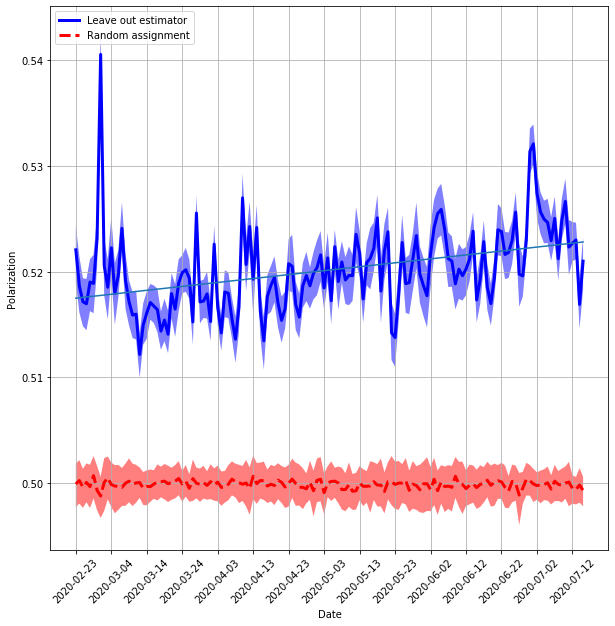

In [68]:
evaluation.plot_aggregated(results, trend_line = True)

#### b. Week-level estimates: 

In [18]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_weekly.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS)
else:
    results = defaultdict(lambda: dict().fromkeys(["true","random"])) #store for each day
    for data in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, batch_size = 7, 
                                dtype = dtypes, filter_fun = ff)):
        #get period:
        dates = pd.to_datetime(data.day)
        date_min = dates.min().strftime('%d/%m')
        date_max = dates.max().strftime('%d/%m')
        week = date_min + '-' + date_max
        
        #fit model
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"].astype(str) #get tweets
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[week]["true"] = model.estimate(parties, users, tweets, 
                                                               level = "aggregate", conf_int = 100)

        #fit randomized model:
        random_parties = data["user-id_str"].astype(str).map(randomized)
        model = ModelPolarization(parties = ["gov", "opp"], limit = 50, ngram_range = (1,2))
        results[week]["random"] = model.estimate(random_parties, users, tweets, 
                                                               level = "aggregate", conf_int = 100)
    results = dict(results) #convert defaultdict to dict
    results = pd.DataFrame.from_dict({(i, j):results[i][j] 
                                  for i in results.keys() 
                                  for j in results[i].keys()}, orient = 'index')
    results.columns = ['date','type','lower_ci','upper_ci','estimate']
    results.to_csv(PATH_RESULTS)

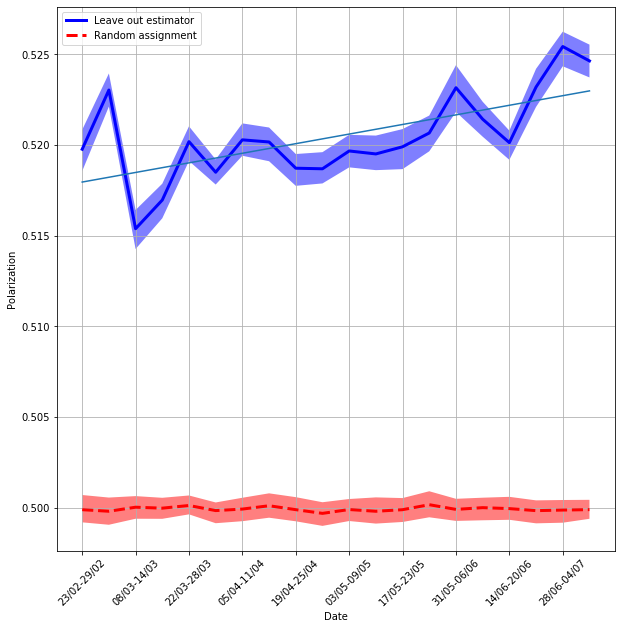

In [19]:
results.set_index(['date','type'], inplace = True)
date = results.reset_index().date.unique()
true_estimate = results.loc[pd.IndexSlice[:, 'true'], 'estimate'].reset_index(drop = True)
true_ci = results.loc[pd.IndexSlice[:, 'true'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
random_estimate = results.loc[pd.IndexSlice[:, 'random'], 'estimate'].reset_index(drop = True)
random_ci = results.loc[pd.IndexSlice[:, 'random'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
evaluation.plot_aggregated(date, true_estimate, random_estimate, true_ci, random_ci, trend_line = True, tick_freq = 2)
plt.show()

#### c. Day-level rolling estimates

In [33]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_rolling_window.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS)
else:
    results = defaultdict(dict) #store results
    fmt = '%Y_%m_%d' #date formatting for files
    START2 = (datetime.strptime(START, fmt) + timedelta(days = 7)).strftime(fmt)
    reader = partial(read_files, path = PATH_DATA, day_to = END, dtype = dtypes, filter_fun = ff)
    reader_weekly = reader(day_from = START, batch_size = 7)
    reader_daily = reader(day_from = START2, batch_size = 1)
    data = next(reader_weekly) #get first week
    data['day'] = pd.to_datetime(data['day']) #convert to datetime
    for df in tqdm(reader_daily):
        df['day'] = pd.to_datetime(df['day'])
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2), log = logging.INFO)
        model.prefit(data["lemmatized"].astype(str).to_numpy())
        #fit only for the middle date from the window
        window = data['day'].unique() #current window
        mid_date = sorted(window)[3] #get middle entry
        data_mid = data[data['day'] == mid_date]
        mid_date_str = np.datetime_as_string(mid_date, unit = 'D') #convert to string for key
        results[mid_date_str]['true'] = model.estimate(data_mid['source'], 
                                                         data_mid['user-id_str'], 
                                                         data_mid['lemmatized'], 
                                                         level = 'aggregate',
                                                         conf_int = 100)
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2), log = logging.INFO)
        model.prefit(data["lemmatized"].astype(str).to_numpy())
        random_parties = data_mid["user-id_str"].astype(str).map(randomized)
        results[mid_date_str]['random'] = model.estimate(random_parties, 
                                                     data_mid['user-id_str'], 
                                                     data_mid['lemmatized'], 
                                                     level = 'aggregate',
                                                     conf_int = 100)

        data = data[data.day != data.day.min()] #filter out oldest day
        data = data.append(df)

    results = pd.DataFrame.from_dict({(i, j):results[i][j] 
                                  for i in results.keys() 
                                  for j in results[i].keys()}, orient = 'index')
    results.index.names = ['date','type']
    results.to_csv(PATH_RESULTS)

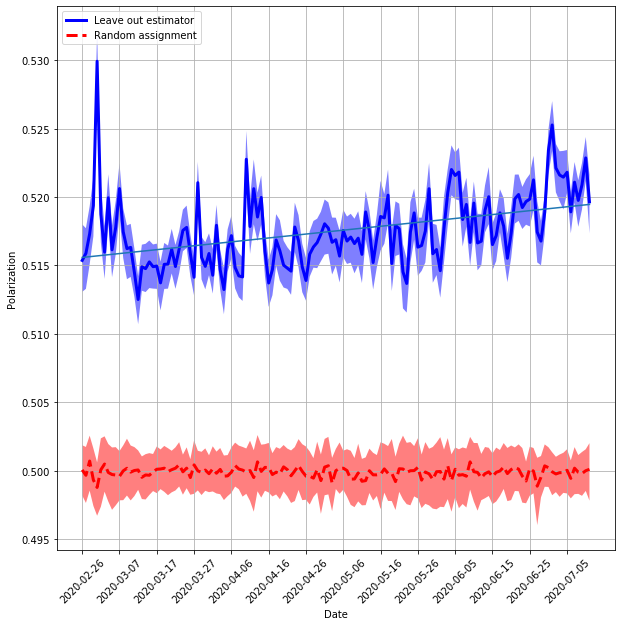

In [34]:
results.set_index(['date','type'], inplace = True)
date = results.reset_index().date.unique()
true_estimate = results.loc[pd.IndexSlice[:, 'true'], 'estimate'].reset_index(drop = True)
true_ci = results.loc[pd.IndexSlice[:, 'true'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
random_estimate = results.loc[pd.IndexSlice[:, 'random'], 'estimate'].reset_index(drop = True)
random_ci = results.loc[pd.IndexSlice[:, 'random'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
evaluation.plot_aggregated(date, true_estimate, random_estimate, true_ci, random_ci, trend_line = True, tick_freq = 10)
plt.show()

#### d. Daily rolling estimates by topic

In [5]:
topics = json.load(open(os.path.join(PATH, 'results/topics/mallet/best_model_topics.json'), 'r'))
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_topics_rolling_window.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS, index_col = [0, 'date','topic'])
else:
    results = defaultdict(lambda: defaultdict(dict)) #store results
    fmt = '%Y_%m_%d' #date formatting for files
    START2 = (datetime.strptime(START, fmt) + timedelta(days = 7)).strftime(fmt)
    reader = partial(read_files, path = PATH_DATA, day_to = END, dtype = dtypes, filter_fun = ff)
    reader_weekly = reader(day_from = START, batch_size = 7)
    reader_daily = reader(day_from = START2, batch_size = 1)
    data = next(reader_weekly) #get first week
    data['day'] = pd.to_datetime(data['day']) #convert to datetime
    data['topic'] = data['lemmatized'].map(topics)
    for df in tqdm(reader_daily):
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2), log = logging.INFO)
        model.prefit(data["lemmatized"].astype(str).to_numpy())
        #fit only for the middle date from the window
        window = data['day'].unique() #current window
        mid_date = sorted(window)[3] #get middle entry
        data_mid = data[data['day'] == mid_date]
        mid_date_str = np.datetime_as_string(mid_date, unit = 'D') #convert to string for key
        for k in np.unique(list(topics.values())):
            data_mid_t = data_mid.loc[data_mid['topic'] == k]
            parties = data_mid_t["source"] #get parties 
            users = data_mid_t["user-id_str"] #get users 
            tweets = data_mid_t["lemmatized"].astype(str) #get tweets
            results[mid_date_str][k] = model.estimate(parties, users, tweets, level = "aggregate", conf_int = None)
        results[mid_date_str] = dict(results[mid_date_str]) #convert it to dict
        
        #remove one day:
        data = data[data.day != data.day.min()] 
        
        #add one day
        df['topic'] = df['lemmatized'].map(topics)
        df['day'] = pd.to_datetime(df['day'])
        data = data.append(df)
    results = dict(results)

    results = pd.DataFrame.from_dict({(i, j):results[i][j] 
                              for i in results.keys() 
                              for j in results[i].keys()}, orient = 'index')

    results.index.names = ['topic','date']
    results.reset_index(inplace = True)
    results[['gov','opp']] = pd.json_normalize(results['n'])
    del results['n']
    results.set_index(['topic','date'], inplace = True)
    results.to_csv(PATH_RESULTS)

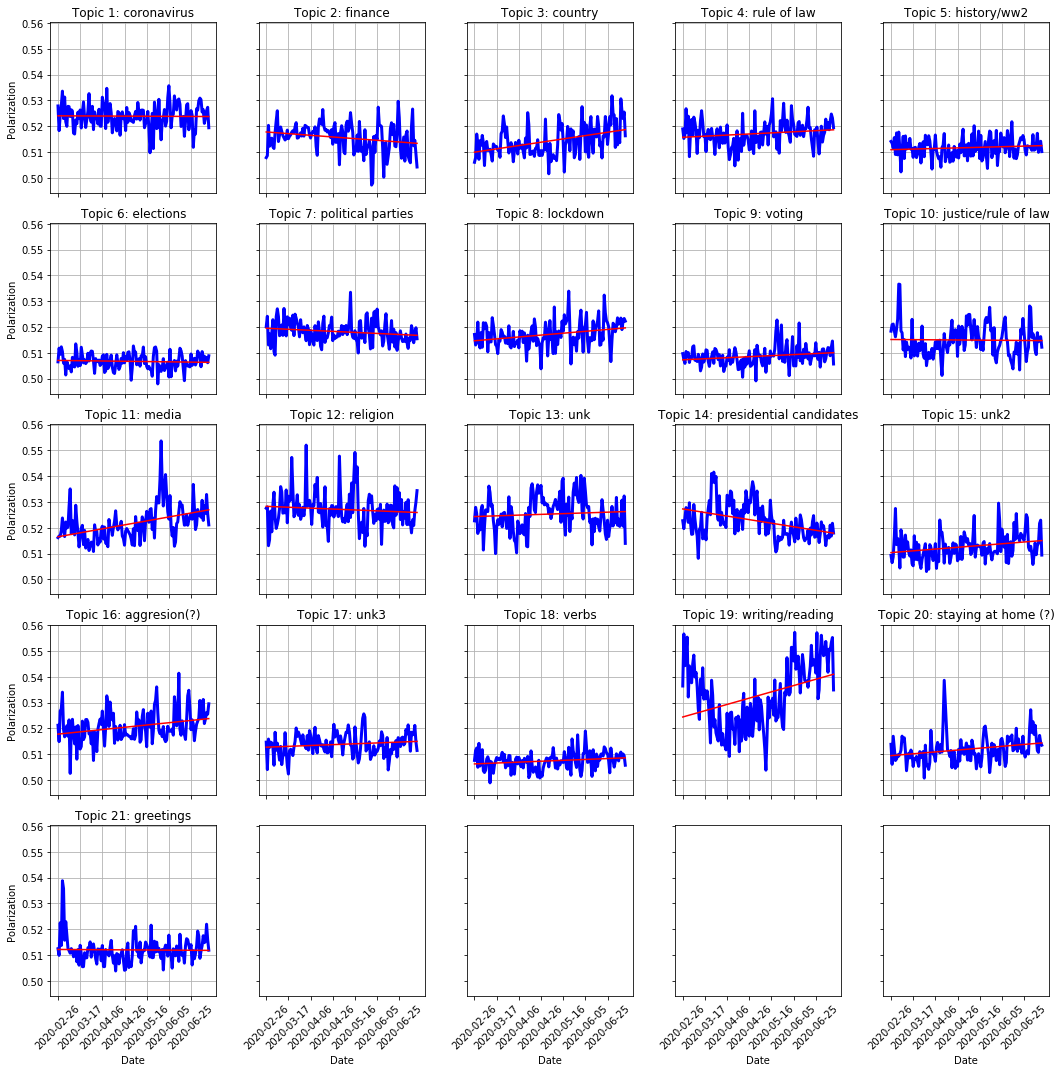

In [26]:
results = results.reset_index()
topic_dict = json.load(open(os.path.join(PATH, 'results/topics/mallet/best_model_topic_dict.json'), 'r'))
evaluation.plot_aggregated_bytopic(results.date, results['point'], results.topic, topic_dict = topic_dict, figsize = (15, 15), trend_line = True)

## 3. Each topic (best-fit LDA-mallet)

In [28]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_mallet_new.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS, index_col = ['topic','date'])
else:
    results = defaultdict(lambda: defaultdict(dict))
    for df in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, batch_size = 1, 
                                dtype = dtypes, filter_fun = ff_topics)):
        #fit vectorizer on all vocabulary:
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        _ = model._vectorize_text(df["lemmatized"].astype(str).to_numpy())
        del _
        gc.collect()
        
        #iterate over each topic:
        for k in np.unique(list(clusters.values())):
            data = df.loc[df['cluster'] == k]
            parties = data["source"] #get parties 
            users = data["user-id_str"] #get users 
            tweets = data["lemmatized"].astype(str) #get tweets
            day = data['day'].unique()[0]
            try:
                results[k][day] = model.estimate(parties, users, tweets, level = "aggregate", conf_int = None)
            except:
                continue
            results[k] = dict(results[k])
    results = dict(results) #convert defaultdict to dict
    results = pd.DataFrame.from_dict({(i, j):results[i][j] 
                                  for i in results.keys() 
                                  for j in results[i].keys()}, orient = 'index')

    results.index.names = ['topic','date']
    results.reset_index(inplace = True)
    results[['gov','opp']] = pd.json_normalize(results['n'])
    del results['n']
    results.set_index(['topic','date'], inplace = True)
    results.to_csv(PATH_RESULTS)

### Plot: 

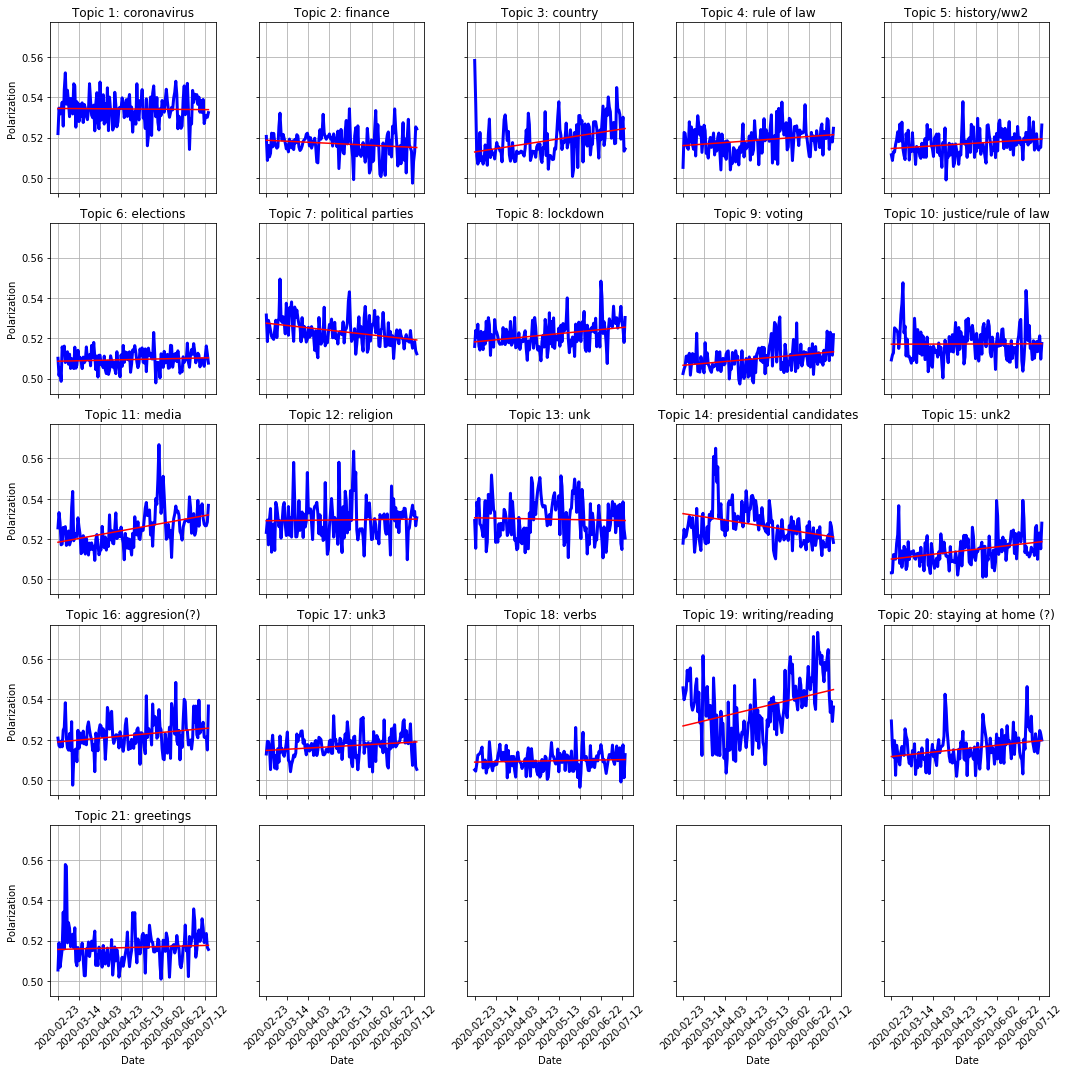

In [34]:
results = results.reset_index()
topic_dict = json.load(open(os.path.join(PATH, 'results/topics/mallet/best_model_topic_dict.json'), 'r'))
evaluation.plot_aggregated_bytopic(results.date, results['point'], results.topic, topic_dict = topic_dict, figsize = (15, 15), trend_line = True)

array(['coronavirus', 'finance', 'country', 'rule of law', 'history/ww2',
       'elections', 'political parties', 'lockdown', 'voting',
       'justice/rule of law', 'media', 'religion', 'unk',
       'presidential candidates', 'unk2', 'aggresion(?)', 'unk3', 'verbs',
       'writing/reading', 'staying at home (?)', 'greetings'],
      dtype=object)

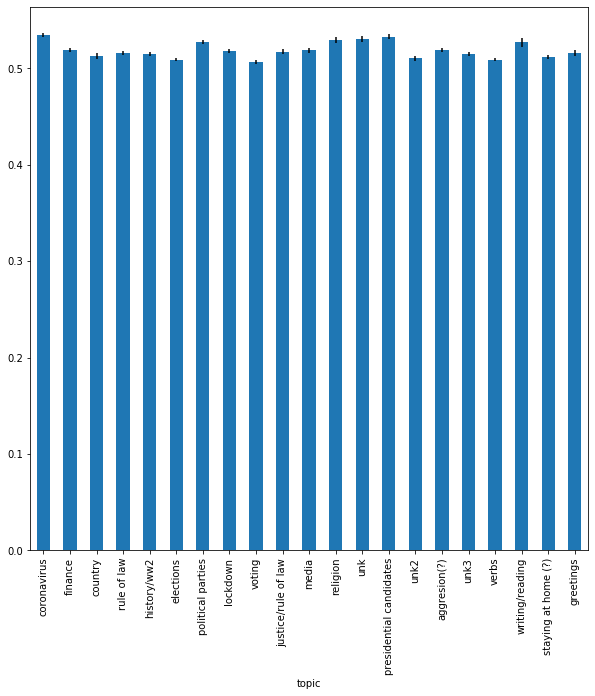

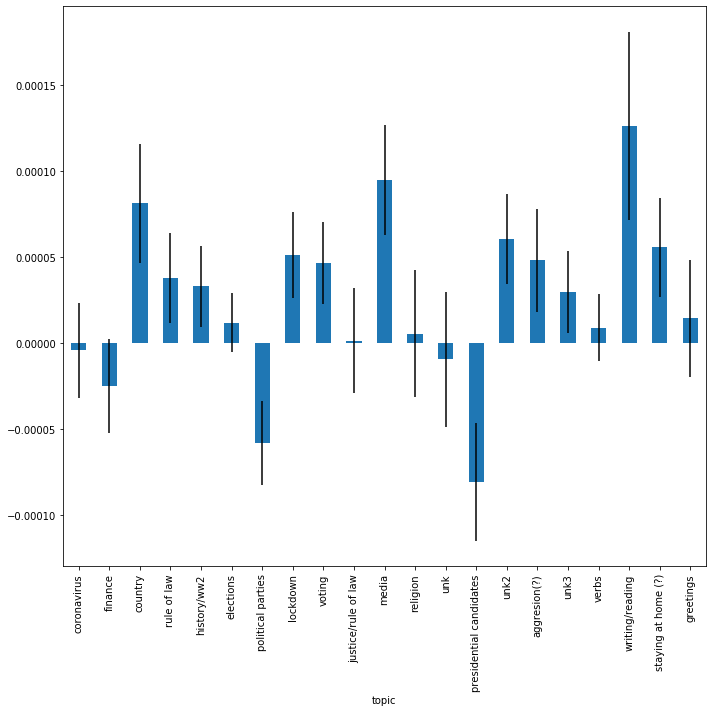

In [97]:
fits = pd.DataFrame(columns = ['lower','upper', 'point','topic'])
date_num = np.arange(len(np.unique(results.reset_index().date)))
X = sm.add_constant(date_num)
for topic, df in results.groupby('topic'):
    model = sm.OLS(df['point'], X)
    fit = model.fit()
    res = fit.conf_int()
    res.columns = ['lower','upper']
    res['point'] = fit.params
    res['topic'] = topic
    fits = fits.append(res)
fits.set_index('topic', inplace = True, append = True)
fits.index.names = ['coef','topic']
fits = fits.reset_index()
fits['topic'] = fits.topic.astype(str).map(topic_dict)
fits['err'] = fits['upper'] - fits['point']
axes = fits.reset_index().groupby(['coef']).plot.bar('topic','point',figsize = (10, 10), yerr = 'err')
for ax in axes:
    ax.get_legend().remove()
    ax.
    #ax.set_xticklabels(fits['topic'].unique(), rotation = 45)
plt.tight_layout()
plt.show()

# OLD STUFF:

## 5. Covid (manual selection)
- excluding retweets
- only coronavirus-related content
- minimum lenght of tweet - 5 (lemmatized, including stopwords)
- maximum minimum number of bigram occurence in one day - 5

In [6]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_covid.p")
if os.path.isfile(PATH_RESULTS):
    results = pickle.load(open(PATH_RESULTS,"rb"))
else:
    wirus_vocab  = "korona|koronawirus|wirus|epidemia|pandemia|choroba|covid|covid19|maseczka|sars|zarażenie|zarażony|zarażać|chorować|ofiary|ofiara|corona|lockdown|szpital"
    DROP_IDS = json.load(open(PATH_DROP, 'r'))
    def filter_fun(df, cols: list, drop_ids: list, stopwords: list):
        df = df.loc[np.logical_not(df.id_str.isin(drop_ids)),:]
        df = df.loc[np.logical_not(df.retweet.apply(lambda x: ast.literal_eval(x))),:]
        df['lemmatized'] = df.lemmatized.astype(str).apply(lambda x: " ".join([x for x in x.split() if x not in stopwords]))
        wirus_ind = df.lemmatized.str.contains(wirus_vocab)
        df = df.iloc[np.where(wirus_ind)[0]]
        return df
    ff = partial(filter_fun, cols = ['lemmatized', 'day', 'source', 'user-id_str'], drop_ids = DROP_IDS, 
                 stopwords = stopwords)
    results = defaultdict(lambda: dict().fromkeys(["true","random"])) #store for each day
    for data in tqdm(read_files(PATH_DATA, ndays = 84, dtype = str, filter_fun = ff)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"] #get tweets
        day = data['day'].unique()[0]
        try:
            model = ModelPolarization(parties = ["gov", "opp"], limit = 5)
            results[day]["true"] = model.estimate(parties, users, tweets, 
                                                                   level = "aggregate", conf_int = 100)
            #randomization
            random_parties = data["user-id_str"].astype(str).map(randomized)
            model = ModelPolarization(parties = ["gov", "opp"], limit = 5)
            results[day]["random"] = model.estimate(random_parties, users, tweets, 
                                                                   level = "aggregate", conf_int = 100)
        except ValueError:
            results[day]['true'] = dict()
            results[day]['random'] = dict()
    results = dict(results) #convert defaultdict to dict
    pickle.dump(results, open(PATH_RESULTS,"wb"))

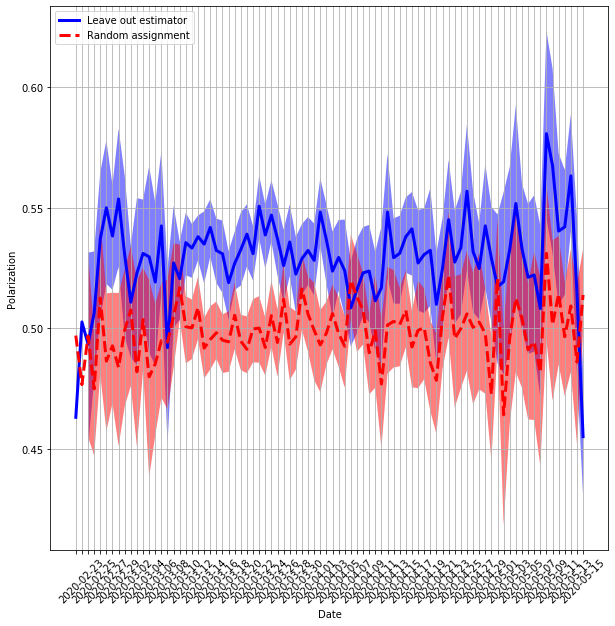

In [7]:
plot_aggregated(results)

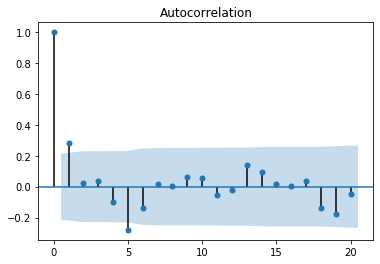

In [14]:
plot_acf(np.array([v['true']['estimate'] for v in results.values()]))
plt.show()

## 6. Elections (manual selection)
- excluding retweets
- only election-related content
- minimum lenght of tweet - 5 (lemmatized, including stopwords)
- maximum minimum number of bigram occurence in one day - 5

In [22]:
PATH_RESULTS = os.path.join(path, "results/polarization/polarization_elections.p")
if os.path.isfile(PATH_RESULTS):
    results = pickle.load(open(PATH_RESULTS,"rb"))
else:
    election_vocab  = "wybory|wyborczy|wybór|kampania|kampanijny|prezydent|prezydencki|głos|głosować|głosowanie"
    DROP_IDS = json.load(open(PATH_DROP, 'r'))
    def filter_fun(df, cols: list, drop_ids: list, stopwords: list):
        df = df.loc[np.logical_not(df.id_str.isin(drop_ids)),:]
        df = df.loc[np.logical_not(df.retweet.apply(lambda x: ast.literal_eval(x))),:]
        df['lemmatized'] = df.lemmatized.astype(str).apply(lambda x: " ".join([x for x in x.split() if x not in stopwords]))
        ind = df.lemmatized.str.contains(election_vocab)
        df = df.iloc[np.where(ind)[0]]
        return df
    ff = partial(filter_fun, cols = ['lemmatized', 'day', 'source', 'user-id_str'], drop_ids = DROP_IDS, 
                 stopwords = stopwords)
    results = defaultdict(lambda: dict().fromkeys(["true","random"])) #store for each day
    for data in tqdm(read_files(PATH_DATA, ndays = 84, dtype = str, filter_fun = ff)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"] #get tweets
        day = data['day'].unique()[0]
        try:
            model = ModelPolarization(parties = ["gov", "opp"], limit = 5)
            results[day]["true"] = model.estimate(parties, users, tweets, 
                                                                   level = "aggregate", conf_int = 100)
            #randomization
            random_parties = data["user-id_str"].astype(str).map(randomized)
            model = ModelPolarization(parties = ["gov", "opp"], limit = 5)
            results[day]["random"] = model.estimate(random_parties, users, tweets, 
                                                                   level = "aggregate", conf_int = 100)
        except ValueError:
            results[day]['true'] = dict()
            results[day]['random'] = dict()
    results = dict(results) #convert defaultdict to dict
    pickle.dump(results, open(PATH_RESULTS,"wb"))

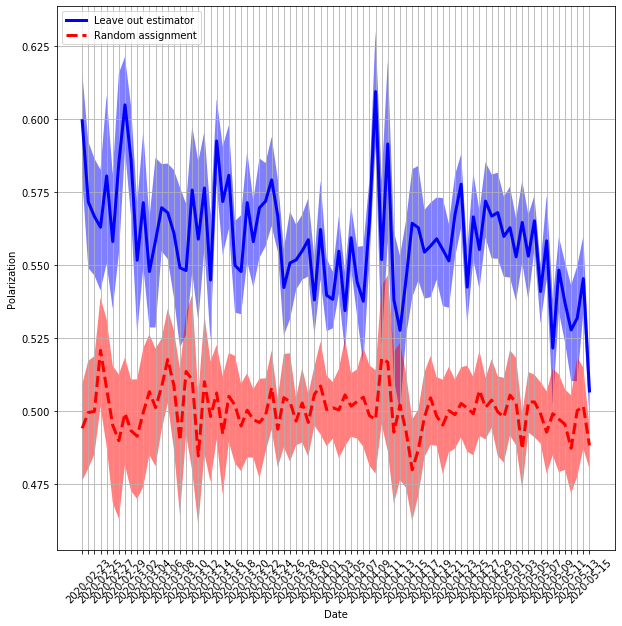

In [25]:
plot_aggregated(results)

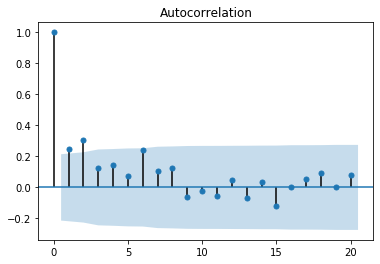

In [27]:
plot_acf(np.array([v['true']['estimate'] for v in results.values()]))

### User-level analysis:

In [7]:
PATH_RESULTS = os.path.join(path, "results/polarization/polarization_users.p")
if os.path.isfile(PATH_RESULTS):
    results = pickle.load(open(PATH_RESULTS,"rb"))
else:
    results = dict()
    for data in tqdm(read_files(PATH_DATA, ndays = 84, dtype = str, filter_fun = ff)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"].astype(str) #get tweets
        day = data['day'].unique()[0]
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[day] = model.estimate(parties, users, tweets,level = "speaker")
    pickle.dump(results, open(PATH_RESULTS, "wb"))

In [8]:
data = pd.DataFrame(columns = ['day','user-id_str','score'])
for day in tqdm(results):
    tmp = pd.DataFrame.from_dict(results[day]).T
    tmp.columns = ['score','user-id_str']
    tmp['day'] = day
    tmp = tmp[data.columns]
    data = data.append(tmp)
data['score'] = data['score'].astype(np.float64)

In [9]:
data.groupby('user-id_str').agg({'score':['mean', 'count']})

score      
                         mean count
user-id_str                        
1000073228935749635  0.514984    36
1000110258           0.256479     2
1000250244091863040  0.510907    28
1000279095182352384  0.518075    36
1000356907142479872  0.533483     2
...                       ...   ...
998250092            0.489349    82
998288203797946368   0.615886     4
998483760420139008   0.542039    14
998836233282387968   0.476248    35
999889490            0.520252    70

[8787 rows x 2 columns]

#### Merge polarization scores with network connectivity data
- merge the daily number of retweets, replies and quotes with the leave-out polarization estimates for each user-day
- for each user, measure the number of connections with his own party and the opposing party using the function `get_opposites`

In [10]:
#load connections data (retweets, replies, etc)
connections = pickle.load(open(os.path.join(PATH, "data/connections.p"), "rb"))
connections = pd.DataFrame(connections)
connections.index.names = ['day', 'user-id_str']
connections.reset_index(inplace = True)
connections['source'] = np.where(connections['user-id_str'].isin(gov), 'gov', 'opp')
cols = [col for col in connections.columns if 'gov' in col or 'opp' in col]
connections[cols] = connections[cols].apply(lambda x: x/connections.total)

data = pd.merge(data, connections) #merge with rt information

In [11]:
stats = pd.read_csv(os.path.join(PATH, 'data/overview.csv'), index_col = 0, dtype = str)
stats = stats[['user-id_str','day','full_text','user-friends_count','user-followers_count']]
data = pd.merge(data, stats)

In [12]:
def get_opposites(data, cols):
    for col in cols:
        gov_col = col + '_gov'
        opp_col = col + '_opp'
        data[col + '_own'] = np.where(data['source'] == 'gov', data[gov_col], data[opp_col])
        data[col + '_other'] = np.where(data['source'] == 'gov', data[opp_col], data[gov_col])
    return data

In [13]:
data = get_opposites(data, ['in_reply_to_user_id_str', 
                                'retweeted_status-user-id_str',
                                'quoted_status-user-id_str', 'sum'])

In [14]:
data['sum_own'] = np.round(data['sum_own']*data['full_text'].astype(int))
data['sum_other'] = np.round(data['sum_other']*data['full_text'].astype(int))

#### Plot average connectivity with own party members/other party members against the average polarization score of a user

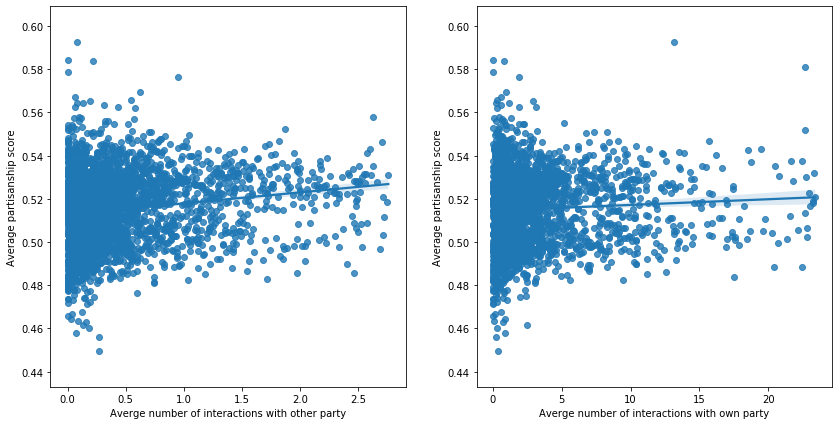

In [124]:
data_plot = data.groupby('user-id_str').agg({'score':['mean','count'],'sum_own':'mean','sum_other':'mean'})


f, ax = plt.subplots(1, 2, figsize=(14, 7))
ax = ax.ravel()
ind = data_plot[('sum_other','mean')] < np.quantile(data_plot[('sum_other','mean')], 0.99)
ind &= data_plot[('score','count')] > 40
data_plot_cut = data_plot[ind]
sns.regplot(data_plot_cut[('sum_other','mean')],data_plot_cut[('score','mean')],ax = ax[0])
ax[0].set_xlabel('Averge number of interactions with other party')
ax[0].set_ylabel('Average partisanship score')


ind = data_plot[('sum_own','mean')] < np.quantile(data_plot[('sum_own','mean')], 0.99)
ind &= data_plot[('score','count')] > 40
data_plot_cut = data_plot[ind]
sns.regplot(data_plot_cut[('sum_own','mean')],data_plot_cut[('score','mean')],ax = ax[1])
ax[1].set_xlabel('Averge number of interactions with own party')
ax[1].set_ylabel('Average partisanship score')
plt.show()

#### Prepare data for panel analysis:
- add constant term
- add lag terms

In [15]:
data["date_num"] = pd.to_datetime(data["day"], format = "%Y-%m-%d").astype(int) #numeric index for date
data = data.set_index(["user-id_str","date_num"]) #set index for panel models
data = data.dropna() #drop missing
data = sm.add_constant(data) #constant
cols_to_shift = [col for col in data.columns if 'own' in col or 'other' in col]
cols_shift = [c + '_lag' for c in cols_to_shift]
data[cols_shift] = data[cols_to_shift].apply(lambda x: x.shift(-1))
data['score_lag'] = data['score'].shift(-1)

In [16]:
mod = RandomEffects(data['score'], data[['const','sum_own_lag', 'sum_other_lag']])
res = mod.fit(cov_type = 'clustered')
print(res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  score   R-squared:                        0.5292
Estimator:              RandomEffects   R-squared (Between):             -0.0002
No. Observations:              259055   R-squared (Within):            9.965e-05
Date:                Fri, Jul 17 2020   R-squared (Overall):          -9.929e-05
Time:                        13:52:35   Log-likelihood                 3.945e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.456e+05
Entities:                        8783   P-value                           0.0000
Avg Obs:                       29.495   Distribution:                F(2,259052)
Min Obs:                       1.0000                                           
Max Obs:                       84.000   F-statistic (robust):             8.7893
                            

In [17]:
mod = RandomEffects(data['score'], data[['const','score_lag', 'sum_own_lag', 'sum_other_lag']])
res = mod.fit(cov_type = 'clustered')
print(res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  score   R-squared:                        0.5795
Estimator:              RandomEffects   R-squared (Between):              0.0998
No. Observations:              259055   R-squared (Within):               0.1059
Date:                Fri, Jul 17 2020   R-squared (Overall):              0.1172
Time:                        13:52:47   Log-likelihood                 4.091e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                    1.19e+05
Entities:                        8783   P-value                           0.0000
Avg Obs:                       29.495   Distribution:                F(3,259051)
Min Obs:                       1.0000                                           
Max Obs:                       84.000   F-statistic (robust):             3348.9
                            

### Tweet-level analysis
- obtain the polarization scores for individual tweets, to manually evaluate which Tweets get highest/lowest polarization scores

In [5]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_tweets.p")
if os.path.isfile(PATH_RESULTS):
    results = pickle.load(open(PATH_RESULTS,"rb"))
else:
    results = dict()
    for data in tqdm(read_files(PATH_DATA, ndays = 84, dtype = str, filter_fun = ff)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"].astype(str) #get tweets
        ids = data['id_str'].astype(str)
        day = data['day'].unique()[0]
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[day] = model.estimate(parties, users, tweets, text_id = ids, level = "speech")
    pickle.dump(results, open(PATH_RESULTS, "wb"))

In [16]:
data = pd.DataFrame(columns = ['score','id_str','day'])
for k in tqdm(results):
    tmp = pd.DataFrame(results[k]).T
    tmp['day'] = k
    tmp.columns = data.columns
    data = data.append(tmp)
data['text'] = np.nan
for df in tqdm(read_files(PATH_DATA, ndays = 84, dtype = str, filter_fun = ff)):
    text_dict = df.set_index('id_str')['full_text'].to_dict()
    ind = data.day == df.day.unique()[0]
    data.loc[ind]['text'] = data.loc[ind]['id_str'].map(text_dict)

### Vocabulary analysis
- Evaluate polarity of users' vocabulary - see which tokens were most and least associated with the government and how that has changed over time

In [125]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_vocab.p")
if os.path.isfile(PATH_RESULTS):
    results = pickle.load(open(PATH_RESULTS,"rb"))
else:
    results = dict()
    for data in tqdm(read_files(PATH_DATA, ndays = 84, dtype = str, filter_fun = ff)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"].astype(str) #get tweets
        day = data['day'].unique()[0]
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[day] = model.get_posteriors(parties, users, tweets)
    pickle.dump(results, open(PATH_RESULTS, "wb"))

In [126]:
def plot_word_partisanship(results, word):
    changes = {day:values[word] if word in values else None for day, values in results.items()}
    changes = pd.DataFrame.from_dict(changes, orient = 'index', columns = [word])
    changes = changes.interpolate(method = 'linear', limit_direction = 'both')
    return changes

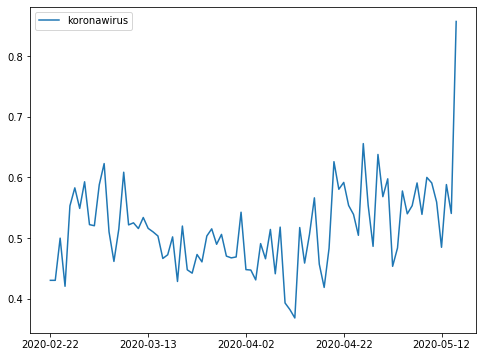

In [129]:
fig, ax = plt.subplots(figsize = (8, 6))
plot_word_partisanship(results, 'koronawirus').plot(ax = ax)
plt.show()

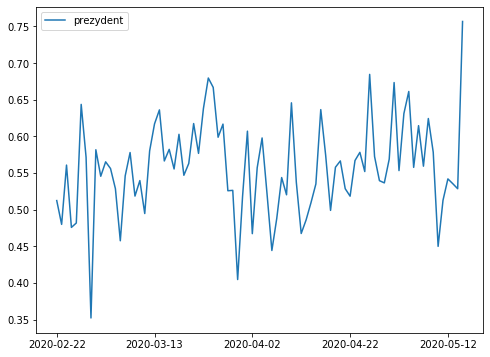

In [130]:
fig, ax = plt.subplots(figsize = (8, 6))
plot_word_partisanship(results, 'prezydent').plot(ax = ax)
plt.show()

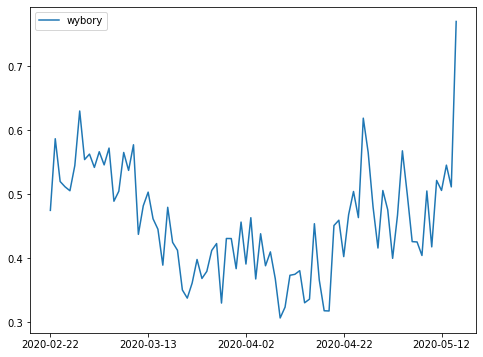

In [131]:
fig, ax = plt.subplots(figsize = (8, 6))
plot_word_partisanship(results, 'wybory').plot(ax = ax)
plt.show()